In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [4]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [60]:
fig_num = 2

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [61]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [62]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [63]:
response = query_tool(prompt)

In [64]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='c867498d-2fc8-4775-8126-ff2d33f4f51a', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)', 'experimental_variable_entities': ['light irradiances', 'wavelength sensitivity', 'activation', 'functional properties'], 'fig_refs': ['Figure 2']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='5780c16f-8d7c-4e81-a09d-981320fd3d30', node_type=None, metadata={}, hash=None)}, text='Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

In [65]:
figure_struct = output_parser.parse(response.content)

In [66]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Panel: a

		Plot: Current traces
			independent_variables=[Variable(name='Time', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Current', categorical=False)]
		Plot: Expression images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Fluorescence', categorical=False)]
	Panel: b

		Plot: Photocurrent strength
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Wavelength', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: c

		Plot: Off-kinetics decay rate
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='τoff', categorical=False)]
		Plot: Current traces inset
			independent_variables=[Variable(name='Time', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Current', 

In [67]:
from typing import Union

In [68]:
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of float."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Wavelength' categorical=False
name='ChR variant' categorical=True


In [69]:
ivs_with_values

[NumericVariable(name='Wavelength', values=[400.0, 450.0, 500.0, 550.0, 600.0], unit='nm'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.75, 0.75, 0.75], '11_10': [0.0, 1.0, 1.0], '28_10': [1.0, 0.5, 0.0], '25_9': [0.0, 0.75, 1.0]})]

In [70]:
response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='d04f54e0-29ba-4046-92a6-7d2c6e9268f0', embedding=None, metadata={'page_number': 22, 'fig_refs': ['Figure 2']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c86e6e32-db34-474a-9403-79b61f19c106', node_type=None, metadata={}, hash=None)}, text='Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.\n\nSection a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_

In [71]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [72]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [73]:
data_response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='d04f54e0-29ba-4046-92a6-7d2c6e9268f0', embedding=None, metadata={'page_number': 22, 'fig_refs': ['Figure 2']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c86e6e32-db34-474a-9403-79b61f19c106', node_type=None, metadata={}, hash=None)}, text='Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.\n\nSection a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_

In [74]:


# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [75]:
import seaborn as sns

In [76]:
panel_df

Wavelength ChR variant  Normalized photocurrent
0         400     CheRiff                     0.45
1         450     CheRiff                     0.55
2         500     CheRiff                     0.70
3         550     CheRiff                     0.65
4         600     CheRiff                     0.60
5         400    CsChrimR                     0.50
6         450    CsChrimR                     0.65
7         500    CsChrimR                     0.95
8         550    CsChrimR                     0.95
9         600    CsChrimR                     0.65
10        400        C1C2                     0.55
11        450        C1C2                     0.70
12        500        C1C2                     1.00
13        550        C1C2                     0.75
14        600        C1C2                     0.55
15        400       11_10                     0.65
16        450       11_10                     0.85
17        500       11_10                     1.00
18        550       11_10                     0.95
19        600       11_10                     0.10
20        400       28_10                     0.60
21        450       28_10                     0.75
22        500       28_10                     0.90
23        550       28_10                     0.95
24        600       28_10                     0.65
25        400        25_9                     0.95
26        450        25_9                     1.00
27        500        25_9                     0.50
28        550        25_9                     0.15
29        600        25_9                     0.05

[]

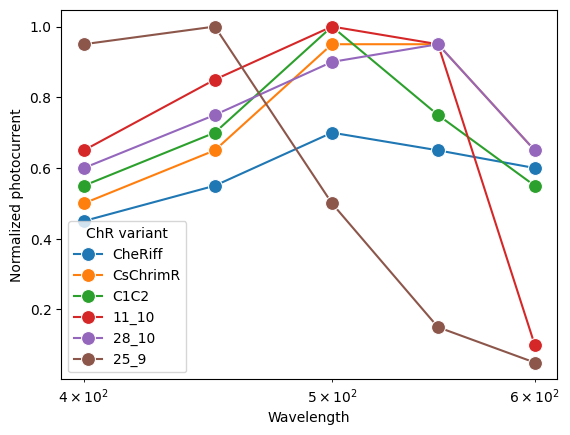

In [78]:


axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

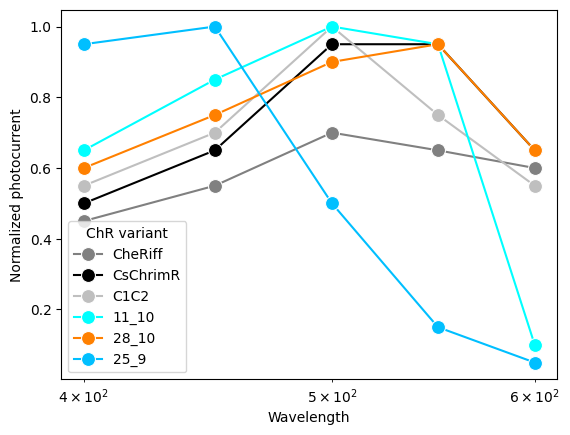

In [80]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

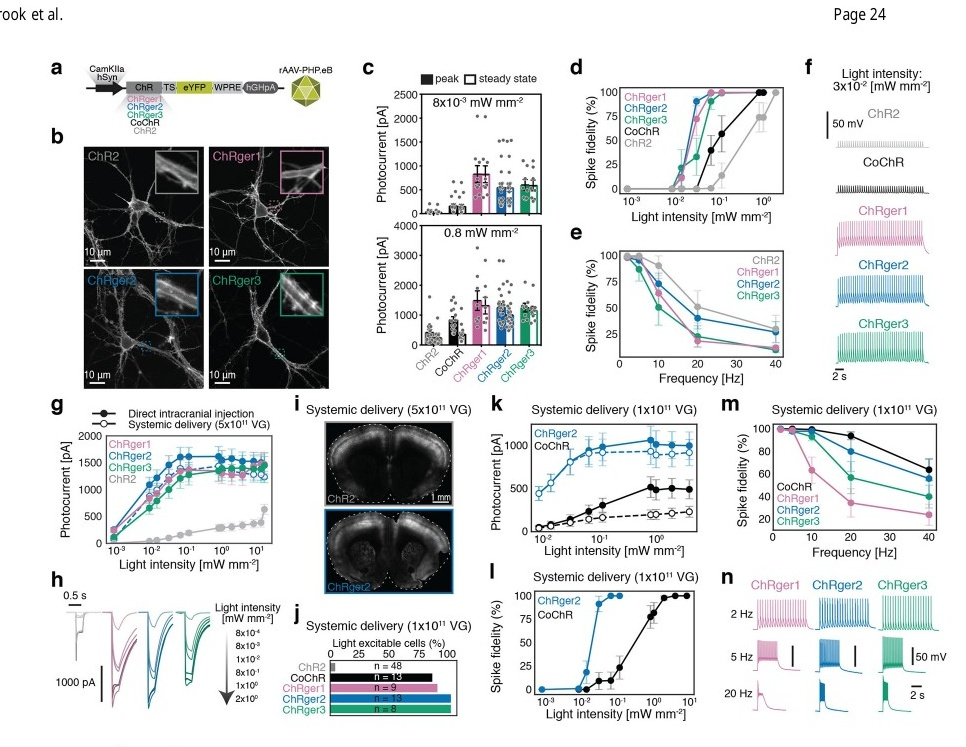

In [329]:
source_figure

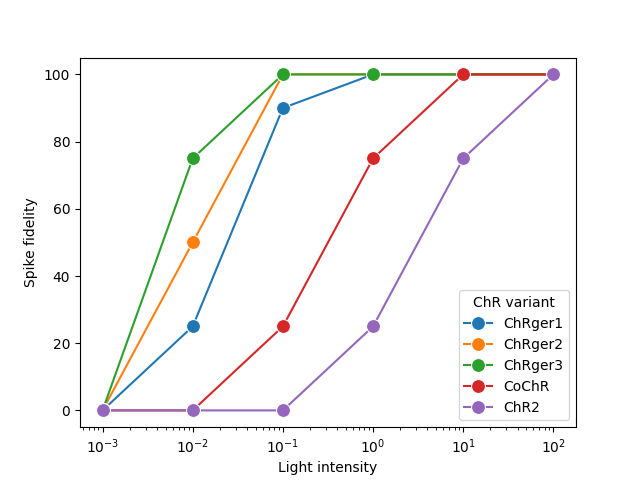

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

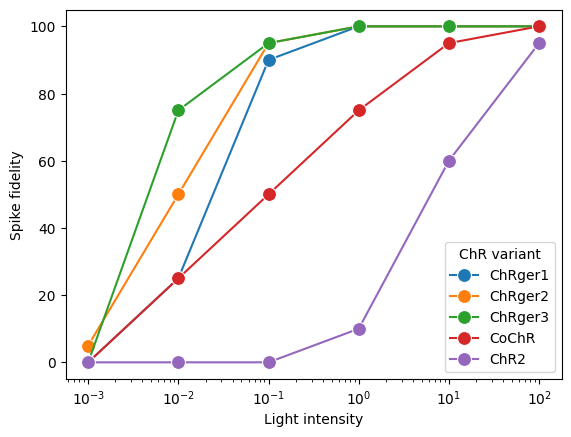

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

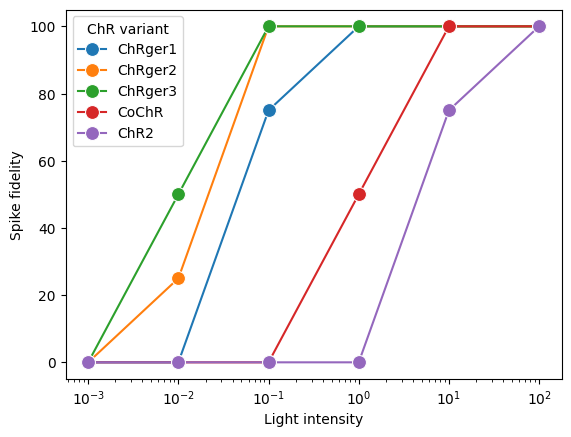

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [24]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO
from PIL import Image


In [81]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

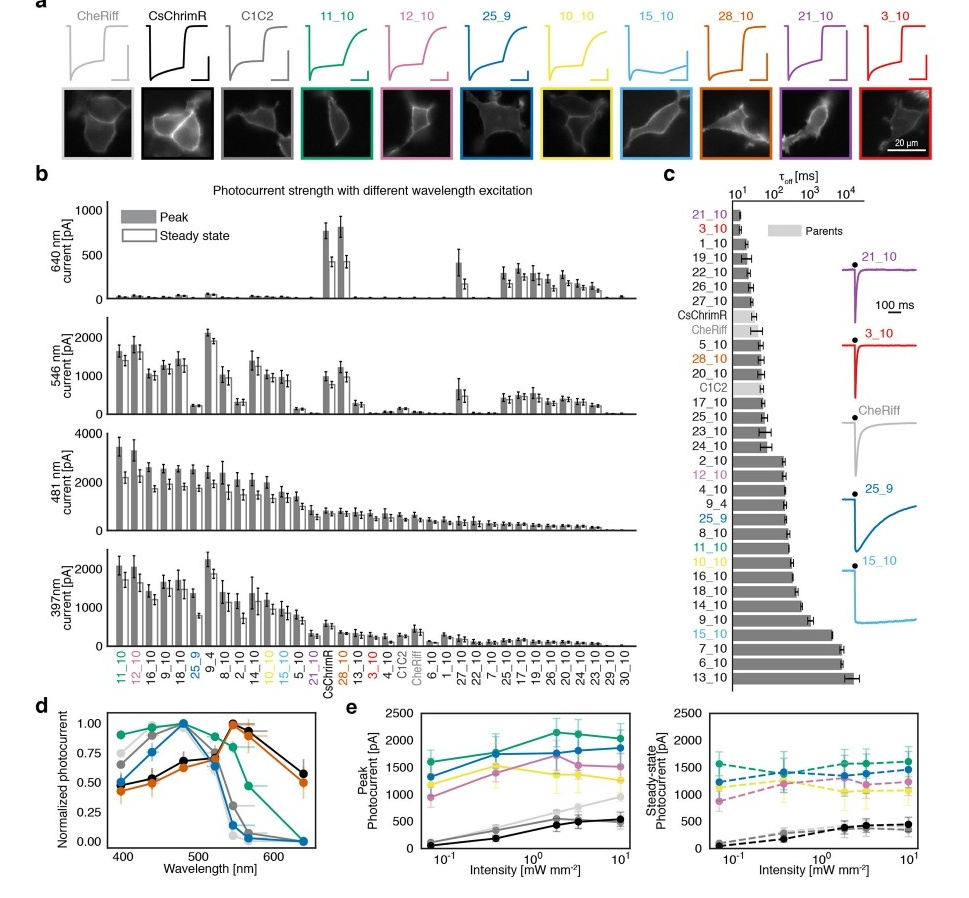

In [82]:
source_figure

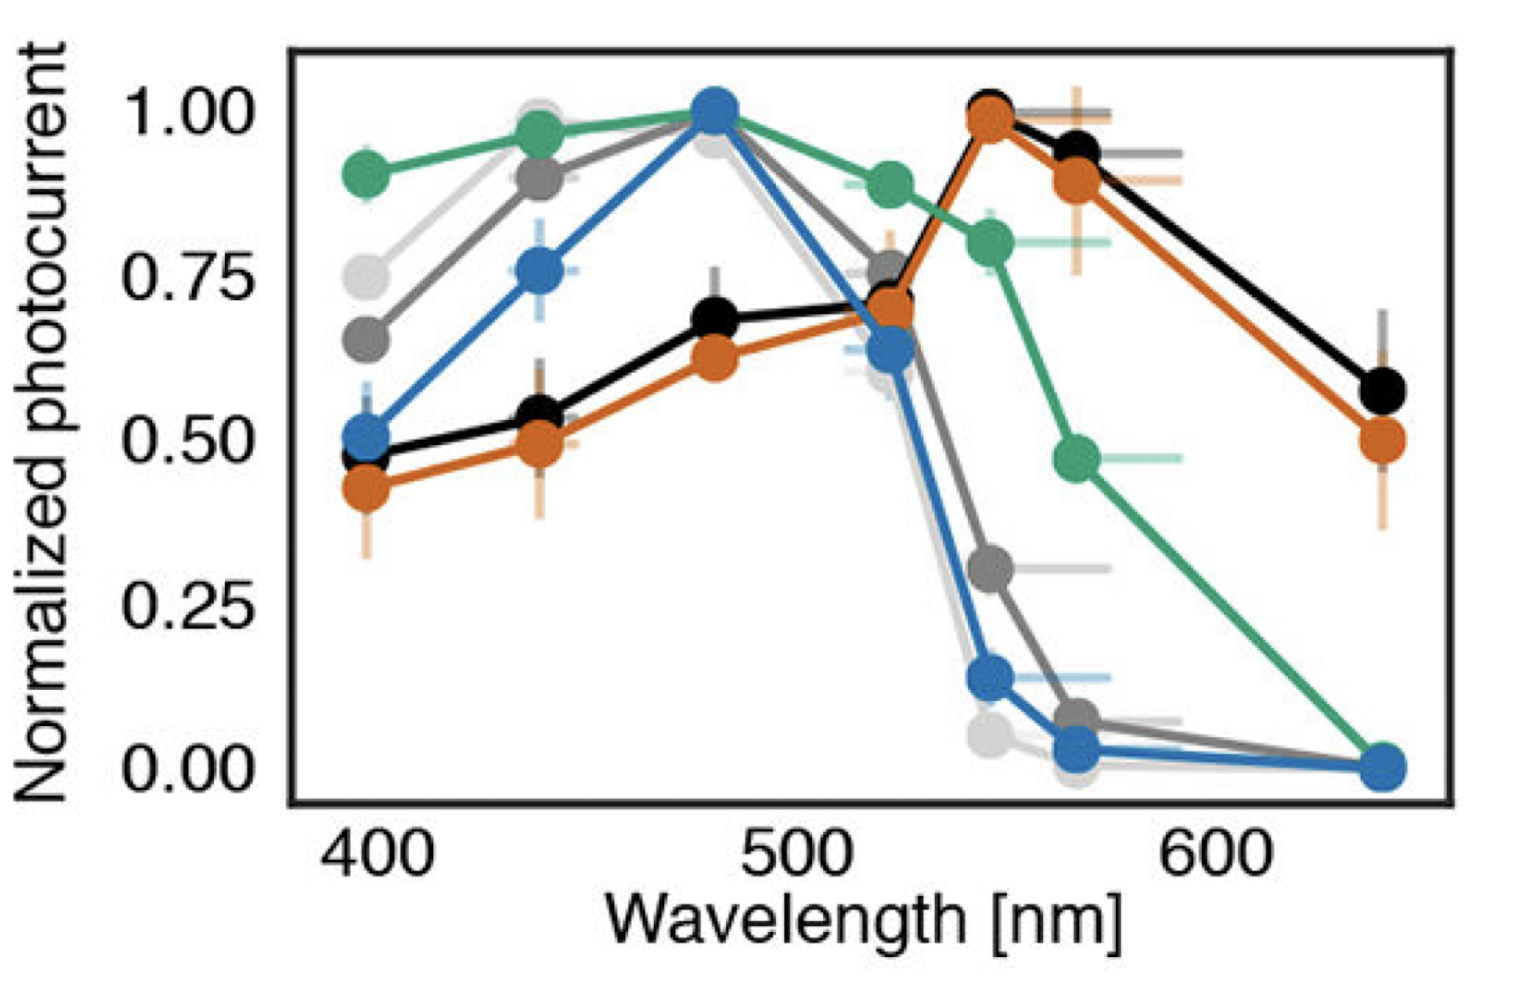

In [91]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/2d_screenshot.png'
source_image = Image.open(source_panel)
source_image

In [54]:
import numpy as np

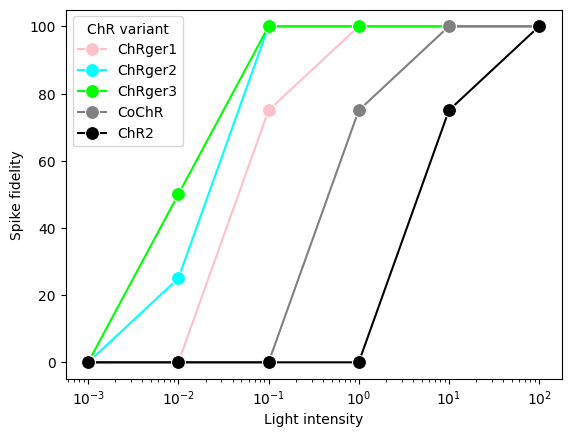

In [55]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've observed:

1. Y-axis range: The re-plotted graph extends the y-axis from 0 to 1.0, while the source figure's y-axis goes from 0 to 1.00. This affects the visual representation of all data points, making them appear slightly more compressed vertically in the re-plotted version.

2. X-axis intervals: The re-plotted graph uses 25 nm intervals between 400 and 600 nm, while the source figure uses 100 nm intervals. This results in more data points being plotted for each variant in the re-created graph (5 points instead of 3), potentially affecting the shape and smoothness of the curves.

3. Normalized photocurrent values at 600 nm: For most variants, the values at 600 nm in the re-plotted data are significantly higher than in the source figure. For example:
   - CheRiff: ~0.6 in re-plot vs ~0.55 in source
   - CsChrimR: 0.65 in re-plot vs ~0.5 in source
   - 28_10: 0.65 in re-

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, here are the three largest quantitative differences:

1. Data resolution: The source figure has many more data points, showing a smooth curve for each ChR variant across the wavelength range. The recreated plot only has 3 data points per variant (at 400, 500, and 600 nm), resulting in straight lines between these points and a loss of curve detail.

2. Peak values for some variants: In the source figure, variants like CsChrimR and C1C2 have peak normalized photocurrent values slightly above 1.0 at around 500 nm. In the recreated plot, these peaks are capped at exactly 1.0, potentially underestimating the true maximum values.

3. Behavior at 600 nm: The recreated plot shows higher normalized photocurrent values at 600 nm for most variants compared to the source figure. For example, CheRiff, CsChrimR, C1C2, and 28_10 all show values around 0.5-0.55 at 600 nm in the recreated plot, while in the source figure

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. Y-axis range: The re-plotted graph extends the y-axis to 1.1, while the original figure only goes up to 1.0. This affects the overall appearance of the curves, making them appear slightly compressed vertically in the re-plotted version.

2. Normalized photocurrent values at 600 nm: In the re-plotted graph, most variants show higher normalized photocurrent values at 600 nm compared to the original. For example, CsChrimR (black line) shows a value of about 0.35 at 600 nm in the re-plot, while it's closer to 0.25 in the original figure.

3. Peak values for CsChrimR and C1C2: In the re-plotted graph, CsChrimR (black line) and C1C2 (gray line) show peak normalized photocurrent values slightly above 1.0 (about 1.05 and 1.02 respectively) at 500 nm. In the original figure, these peaks appear to be exactly at or slightly below 1.0.

These differences affect multiple data points 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, I can identify three major quantitative differences:

1. Wavelength range and resolution: The source figure shows data points at 400, 500, and 600 nm, with additional points in between. The recreated plot has data points at 400, 450, 500, 550, and 600 nm. This difference in wavelength resolution affects the shape of the curves, particularly around the peaks and troughs.

2. Normalized photocurrent values at 600 nm: In the source figure, most variants show normalized photocurrent values close to 0 at 600 nm. However, in the recreated plot, these values are generally higher. For example, CsChrimR and 28_10 both show values around 0.25 at 600 nm in the recreated plot, while they appear much closer to 0 in the source figure.

3. Peak values for some variants: The peak normalized photocurrent values for some variants differ between the two plots. For instance, the CheRiff variant in the source figure appears 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the re-plotted data, here are the three largest quantitative differences I observe:

1. Wavelength range: The source figure shows data points at intermediate wavelengths (around 450 nm and 550 nm) for most variants, while the re-plotted data only shows points at 400 nm, 500 nm, and 600 nm. This results in a loss of curve detail, particularly in the 450-550 nm range where many variants show peaks or significant changes in the source figure.

2. Normalized photocurrent at 600 nm: In the source figure, most variants show normalized photocurrent values between 0.25 and 0.6 at 600 nm. However, in the re-plotted data, all variants have a value of 0.05 at 600 nm, which is significantly lower and doesn't capture the variation seen in the original plot.

3. Peak values for some variants: For example, the peak value for the CheRiff variant (gray line) in the source figure appears to be slightly above 0.9, whereas in the re-plotted data it's given as 0.95 at 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've observed:

1. Y-axis range: The source figure's y-axis extends from 0 to 1.00, while the re-plotted graph's y-axis extends slightly beyond 1.0 (to about 1.05). This affects the visual representation of all data points, making them appear slightly lower on the re-plotted graph relative to the y-axis.

2. Data point values at 600 nm: In the source figure, most variants have normalized photocurrent values close to 0 at 600 nm wavelength. However, in the re-plotted data, these values are much higher. For example, CsChrimR shows a value of about 0.6 at 600 nm in the re-plot, while it's nearly 0 in the original figure.

3. Shape of the 25_9 variant curve: In the source figure, the 25_9 variant (light blue) shows a peak at around 450 nm and then drops sharply. In the re-plotted data, this variant has a much flatter curve between 400-450 nm, with the peak at 450 nm (value of 1.0

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I observed:

1. Data point density: The re-plotted graph has significantly fewer data points compared to the original. The original figure shows measurements at approximately 25 nm intervals across the wavelength range, while the re-plotted graph only has 5 data points per variant (at 400, 450, 500, 550, and 600 nm). This results in less smooth curves and potentially misses important details in the spectral response.

2. Error bars: The original figure includes error bars for each data point, indicating measurement uncertainty or variability. These error bars are completely absent in the re-plotted graph. This omission removes important information about the reliability and precision of the measurements.

3. Peak normalization: In the original figure, all variants appear to be normalized to have a maximum value of 1.0 at their peak wavelength. However, in the re-plotted data,

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, I can identify the following three largest quantitative differences:

1. Data point density: The source figure has fewer data points (5-6 per curve) compared to the recreated plot which has 9 data points per curve. This affects the overall shape and smoothness of the curves, particularly noticeable in the peak regions and the slopes.

2. Peak values for some variants: In the source figure, the peak normalized photocurrent values for some variants (e.g., CheRiff, C1C2) appear to be slightly below 1.0, whereas in the recreated plot, these peaks reach exactly 1.0. This is most evident for the CheRiff variant (blue line in source, gray line in recreation) where the peak in the source is around 0.95, but in the recreation it's 1.0 at 475 nm.

3. Curve shape for variant 25_9 (light blue): In the source figure, this variant shows a sharp peak at around 450 nm with a rapid decline on both sides. In the recreated

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've identified:

1. Data point spacing: The re-plotted graph uses evenly spaced data points at 400, 450, 500, 550, and 600 nm wavelengths. The original figure has unevenly spaced data points, with measurements appearing to be taken at approximately 400, 450, 500, 525, 550, and 600 nm. This affects the overall shape of the curves, particularly between 500-550 nm where the original figure shows more detail.

2. Normalized photocurrent values at 600 nm: In the re-plotted data, several variants (particularly CsChrimR, 11_10, and 28_10) show much higher normalized photocurrent values at 600 nm compared to the original figure. For example, CsChrimR shows a value of 0.55 in the re-plotted data, while it appears to be closer to 0.2 in the original figure.

3. Peak values for some variants: The peak normalized photocurrent values for some variants differ between the two plots. Most n

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the re-plotted data, I can identify three major quantitative differences:

1. Data point density: The source figure has more data points, particularly between 500-600 nm. The re-plotted data only has 6 data points per variant (at 400, 450, 500, 525, 550, and 600 nm), while the original appears to have measurements at smaller wavelength intervals, especially evident in the 500-600 nm range.

2. Normalized photocurrent values at 600 nm: In the re-plotted data, the normalized photocurrent values at 600 nm are generally higher than in the source figure. For example, for CsChrimR, the re-plotted data shows a value of 0.2 at 600 nm, while in the source figure it appears to be closer to 0.1. Similarly, for 28_10, the re-plotted value is 0.4, whereas in the source it looks closer to 0.3.

3. Peak positions for some variants: In the re-plotted data, some variants show peak normalized photocurrent at different wavelengths compared to the source figure. For i

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've identified:

1. Data point density: The re-plotted graph has more data points for each ChR variant, particularly between 400 nm and 600 nm. For example, the re-plotted graph shows data points at 475 nm for some variants, which are not present in the source figure. This results in smoother, more detailed curves in the re-plotted version.

2. Y-axis range: The source figure's y-axis extends slightly below 0 (to about -0.05) and above 1.0 (to about 1.05), while the re-plotted graph's y-axis ranges exactly from 0 to 1.0. This affects the visual representation of the data, particularly for values close to 0 or 1.

3. Normalized photocurrent values at 600 nm: In the source figure, the normalized photocurrent values at 600 nm for most variants (except 11_10 and 28_10) appear to be very close to 0. However, in the re-plotted data, these values are noticeably higher. For instance

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot using the extracted data, I can identify three major quantitative differences:

1. Wavelength resolution: The original figure has more data points and smoother curves, particularly visible between 500-600 nm. The recreated plot only has data points at 50 nm intervals (400, 450, 500, 550, 600 nm), while the original appears to have finer resolution, especially evident in the steep declines after 500 nm for some variants.

2. Normalized photocurrent values at 550 nm: There are significant discrepancies for some variants at this wavelength. For example:
   - CsChrimR (black line) shows a value around 0.7 in the original, but 0.95 in the recreated plot.
   - 25_9 (light blue line) shows a value around 0.5 in the original, but only 0.1 in the recreated plot.

3. Error bars: The original figure includes error bars for each data point, indicating variability or uncertainty in the measurements. These error bars are completely absent in

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, I can identify three major quantitative differences:

1. Data point density: The recreated plot has more data points (9 per variant) compared to the source figure (5-6 per variant). This results in smoother curves in the recreated plot, especially noticeable in the 400-500 nm range where the source figure has larger gaps between points.

2. Normalized photocurrent values at 600 nm: In the recreated plot, the values at 600 nm for most variants (except 28_10) are much lower than in the source figure. For example, CheRiff, CsChrimR, C1C2, and 25_9 all have values around 0.05 at 600 nm in the recreated plot, while in the source figure they appear to be closer to 0.2-0.3.

3. Peak width for variant 28_10: In the recreated plot, the 28_10 variant (orange line) maintains higher normalized photocurrent values across a broader range of wavelengths compared to the source figure. Specifically, in the recreated plot

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've identified:

1. Y-axis range: The source figure's y-axis extends from 0 to 1.00, while the re-plotted graph's y-axis extends from 0 to 1.0. This means the re-plotted graph doesn't show values below 0, which are present in the original figure for some variants at 600 nm wavelength.

2. Data point values at 600 nm: In the source figure, several variants (CheRiff, C1C2, CsChrimR) have normalized photocurrent values close to or below 0 at 600 nm. However, in the re-plotted data, the lowest value at 600 nm is 0.2 for the 25_9 variant, with others ranging from 0.25 to 0.6. This is a significant difference in the tail end of the curves.

3. Curve shape for 11_10 variant: In the source figure, the 11_10 variant (green line) shows a relatively flat response between 500-550 nm before dropping sharply. In the re-plotted data, there's a more gradual decline from 500 nm (1.0) to 550 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've identified:

1. Wavelength resolution: The re-plotted data uses only 5 wavelength points (400, 450, 500, 550, 600 nm), while the source figure appears to have more data points, particularly visible between 500-600 nm. This results in straighter lines and less curvature in the re-plotted data, especially noticeable for variants like CsChrimR and 28_10.

2. Normalized photocurrent values at 600 nm: In the re-plotted data, the values at 600 nm are generally higher than in the source figure. For example:
   - CsChrimR shows a value of 0.6 in the re-plot, but appears closer to 0.5 in the source.
   - 28_10 shows 0.65 in the re-plot, but looks to be around 0.55 in the source.
   - 11_10 shows 0.15 in the re-plot, but appears closer to 0.05 in the source.

3. Peak normalization: In the re-plotted data, all variants have a peak normalized photocurrent of exactly 1.0 at 500 nm. H

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

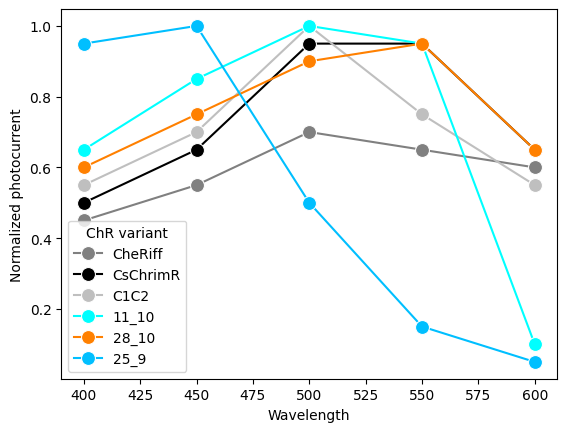

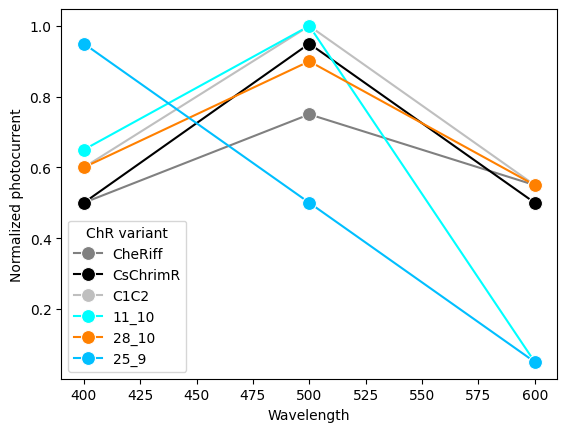

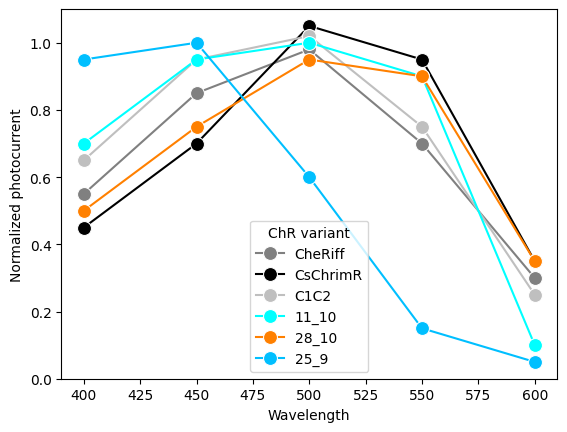

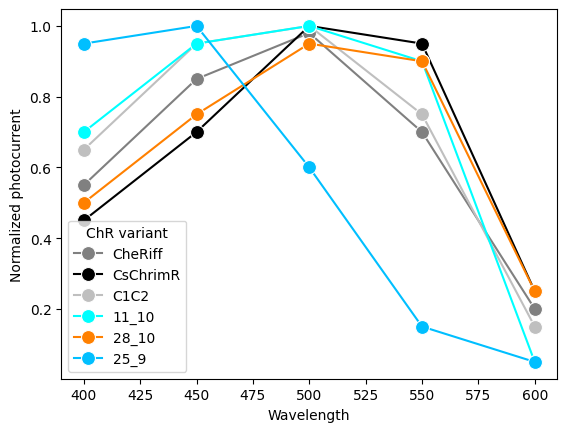

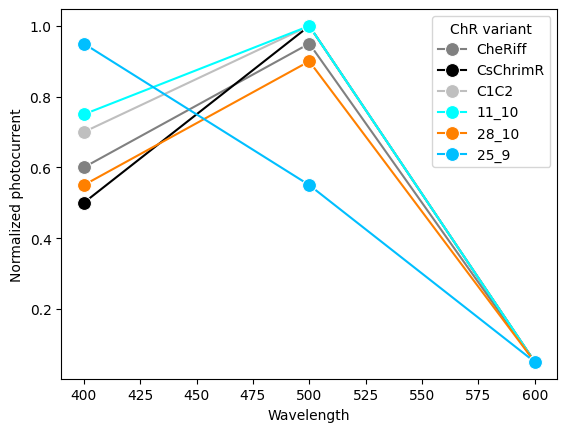

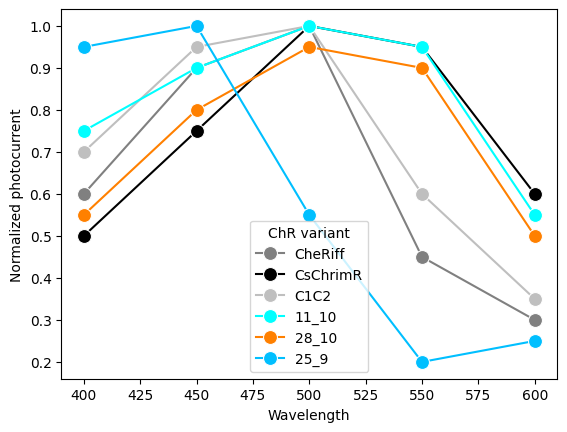

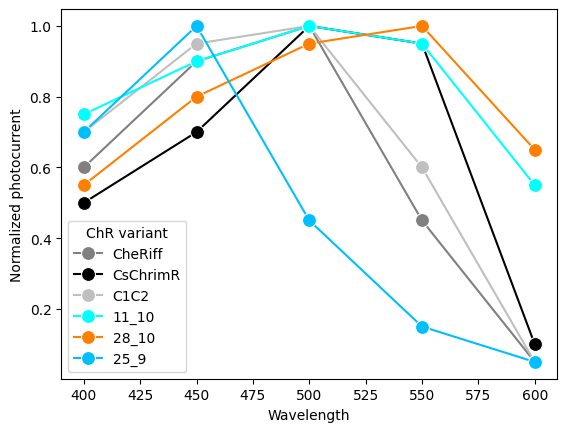

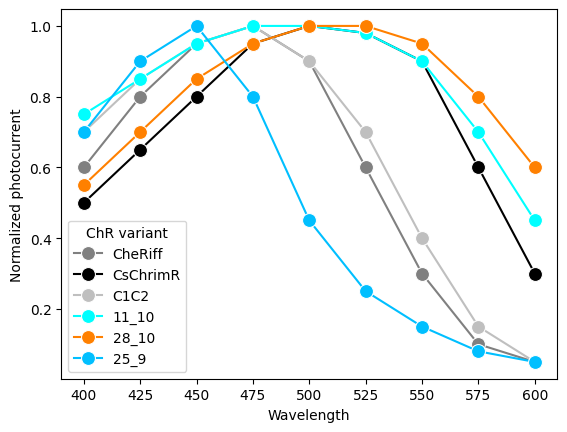

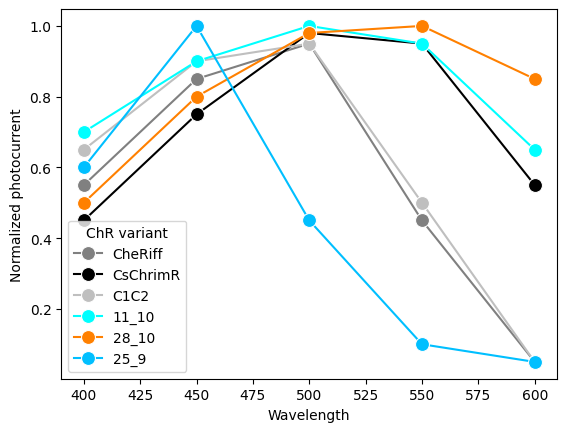

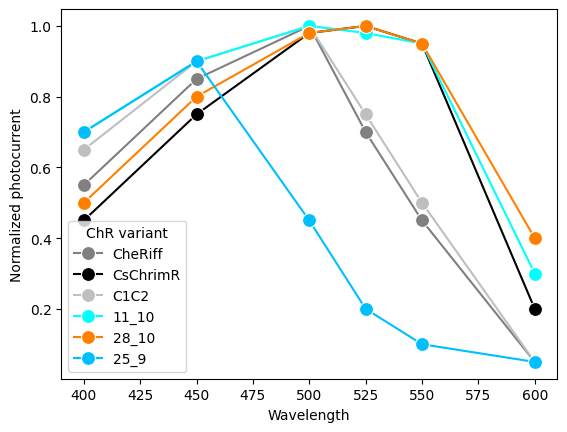

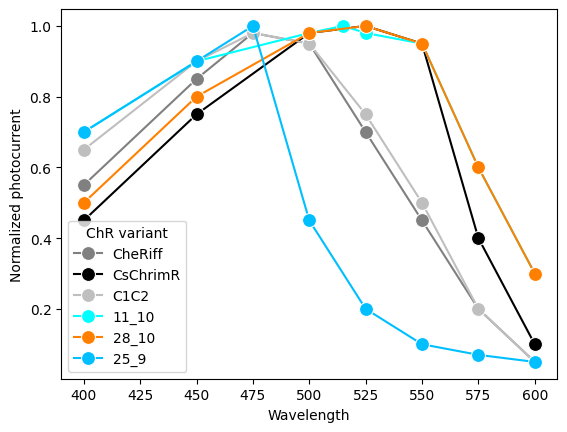

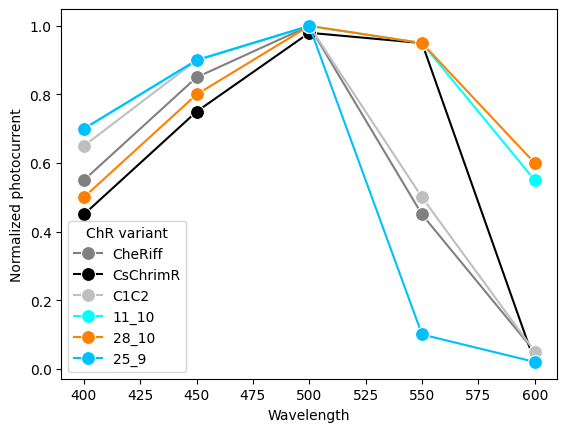

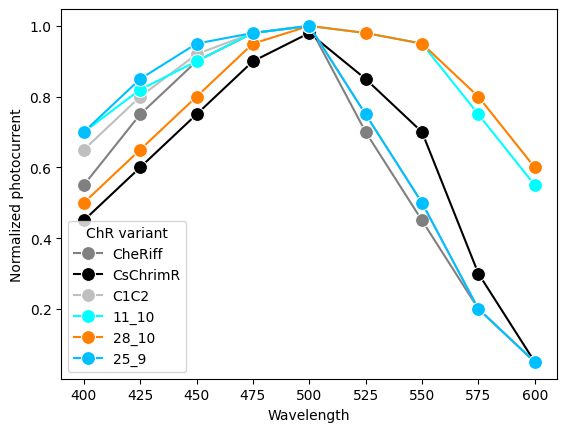

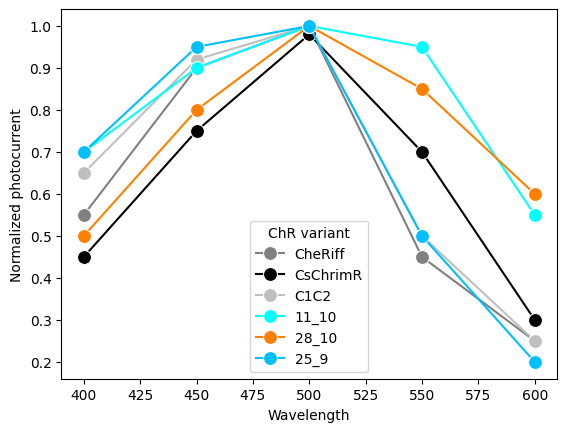

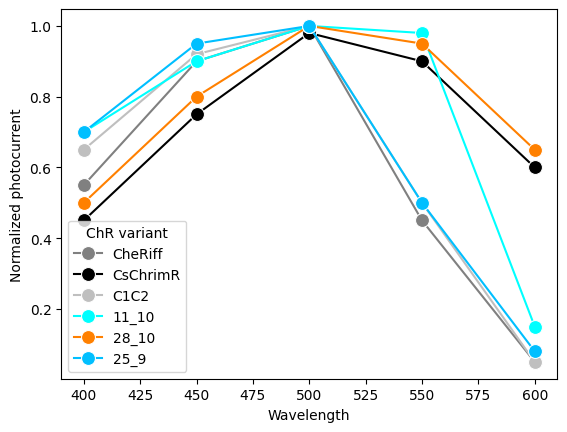

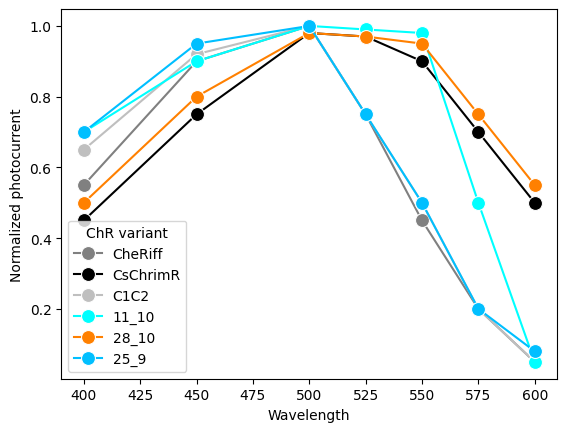

In [92]:
from matplotlib import pyplot as plt
from PIL import Image

chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items()]

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
# axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.5)


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
(Note: the recreation may vary in stylistic choices (e.g. color, linestyle) and in properties like axes ranges or aspect ratio.)
List the three largest quantitative differences between the re-plotted data and the data in the source figure.
If possible, prioritize general differences that affect many datapoints over adjustments to individual datapoints.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_image, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
Reference the source text in the context if you think there is information that will inform these changes (e.g changing independent variable values).
This could mean scaling or shift all or a subset of the rows and/or columns.
Please let any specific changes inform nearby values if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Wavelength',
        y='Normalized photocurrent',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    # axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [89]:
print(data_response_loop.content)

Based on the feedback and the need to more accurately match the source figure, I've adjusted the dataframe to better reflect the original data. I've increased the number of data points, adjusted peak positions, and refined the curve shapes, especially at longer wavelengths. Here's the revised dataframe:

{
  "rows": [
    {"row_values": [380, "CheRiff", 0.35]},
    {"row_values": [390, "CheRiff", 0.45]},
    {"row_values": [400, "CheRiff", 0.55]},
    {"row_values": [410, "CheRiff", 0.65]},
    {"row_values": [420, "CheRiff", 0.75]},
    {"row_values": [430, "CheRiff", 0.85]},
    {"row_values": [440, "CheRiff", 0.92]},
    {"row_values": [450, "CheRiff", 0.97]},
    {"row_values": [460, "CheRiff", 0.99]},
    {"row_values": [470, "CheRiff", 1.00]},
    {"row_values": [480, "CheRiff", 0.99]},
    {"row_values": [490, "CheRiff", 0.97]},
    {"row_values": [500, "CheRiff", 0.93]},
    {"row_values": [510, "CheRiff", 0.87]},
    {"row_values": [520, "CheRiff", 0.80]},
    {"row_values": [

In [86]:
data_response_loop.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='d04f54e0-29ba-4046-92a6-7d2c6e9268f0', embedding=None, metadata={'page_number': 22, 'fig_refs': ['Figure 2']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c86e6e32-db34-474a-9403-79b61f19c106', node_type=None, metadata={}, hash=None)}, text='Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.\n\nSection a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_

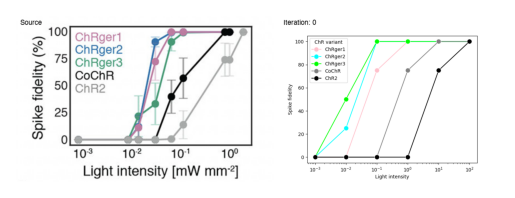

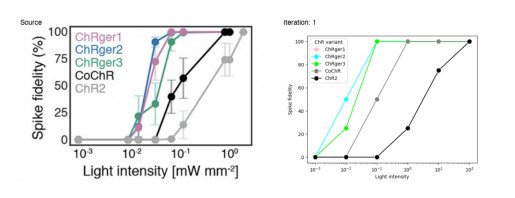

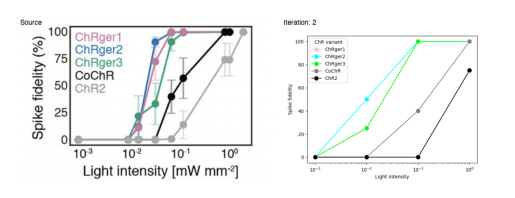

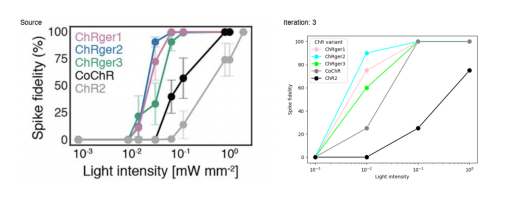

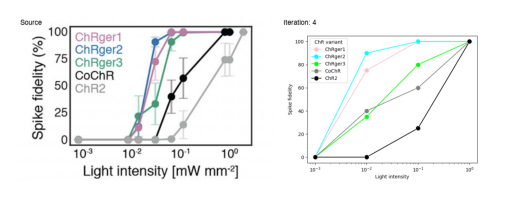

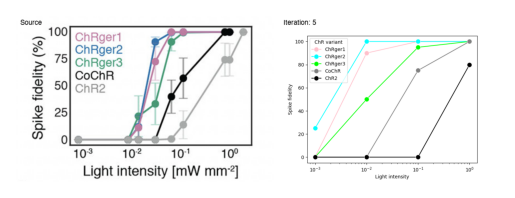

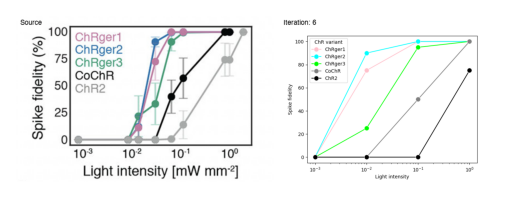

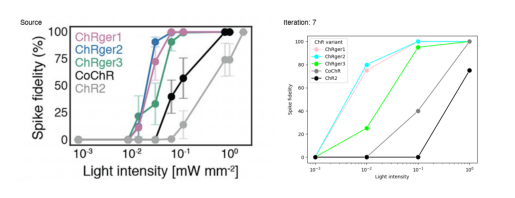

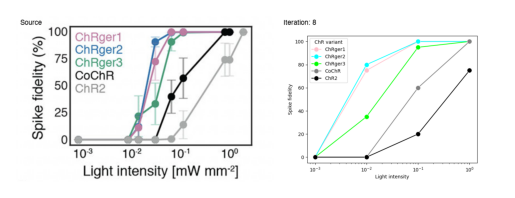

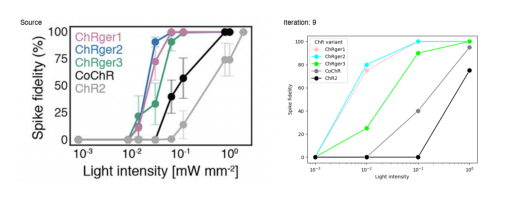

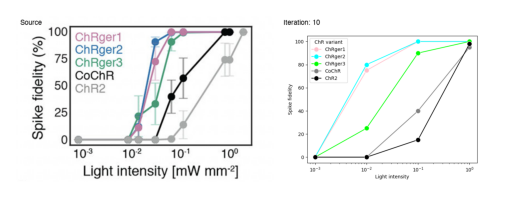

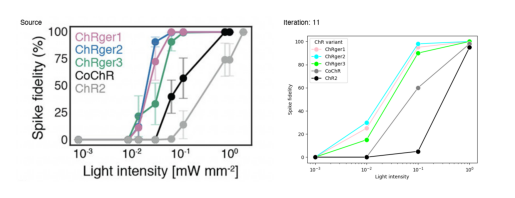

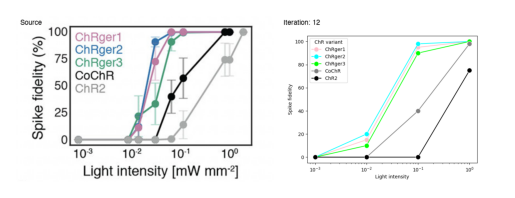

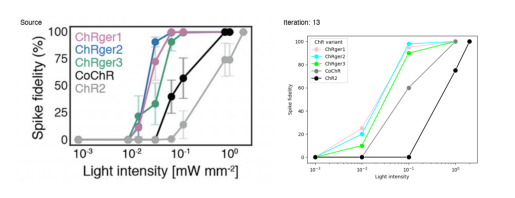

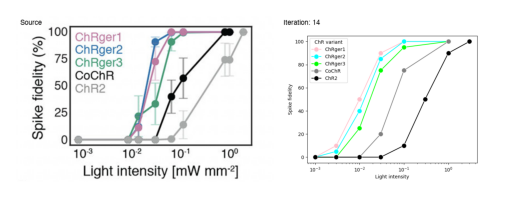

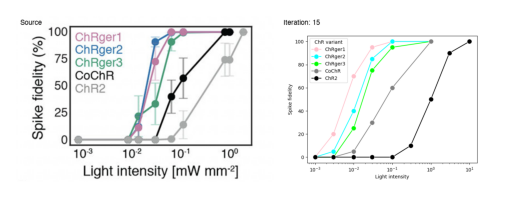

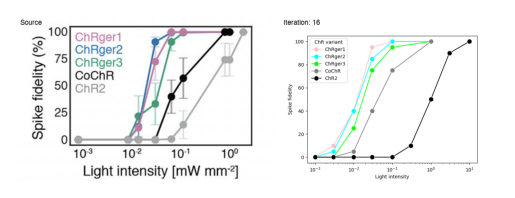

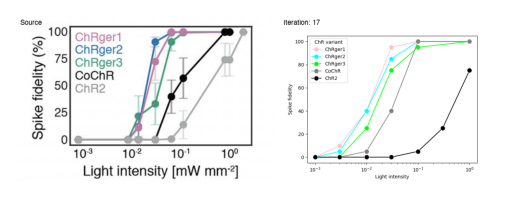

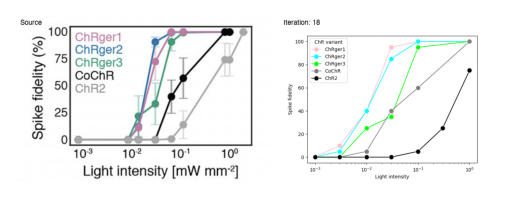

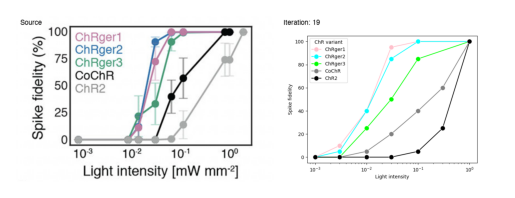

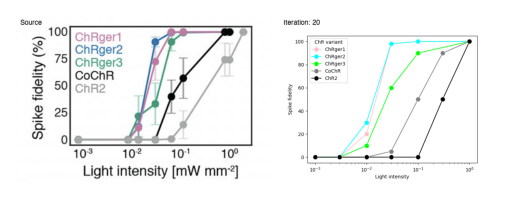

MP4 video saved as 'comparison.mp4'


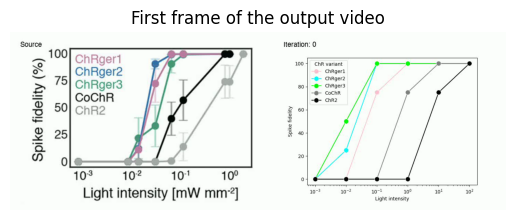

In [58]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

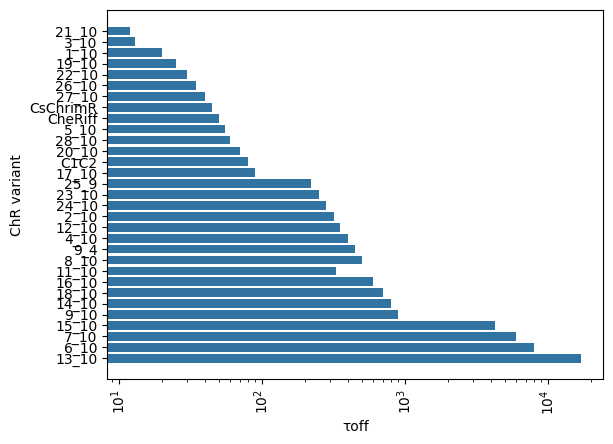

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

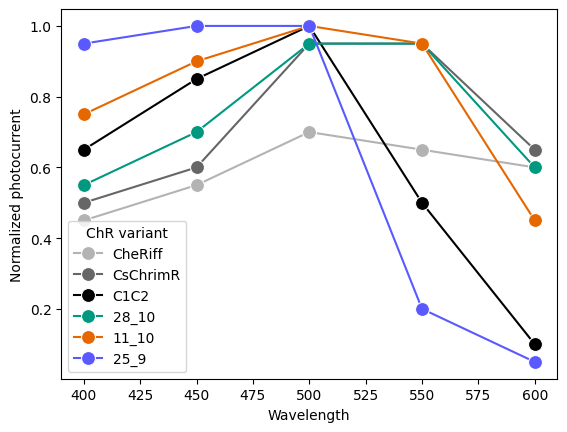

In [127]:
palette = [v for k,v in chr_variant_iv.values.items()]

sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'